# DST Outlier Detector
An attempt to use HAPI-NN to determine outlier DST events. Note, that better methods exists for determining outliers and that the purpose of this notebook is to show the usage of HAPI-NN with real data. 

## Setup
Import HAPI and other packages

In [13]:
from hapiclient import hapi
from datetime import datetime
from hapi_nn import HAPINNTrainer, HAPINNTester, config
import hapi_nn
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
warnings.simplefilter('always')

### HAPI Setup
Set HAPI related parameters

In [3]:
config.MODEL_ENGINE = 'TENSORFLOW'

server = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset = 'OMNI2_H0_MRG1HR'
#Provisional Dst (2015/001-2020/366)
start = '2016-01-01T00:00:00Z'
stop = '2020-01-01T00:00:00Z'

start2 = '2015-01-01T00:00:00Z'
stop2 = '2016-01-01T00:00:00Z'

parameters = 'DST1800'
options = {'logging': True, 'usecache': True, 'cachedir': './hapicache'}

## Create HAPI Trainer and Tester
Begin testing HAPI-NN

### Parameters

In [4]:
# Note the period size has an effect on the duration of outliers that can be detected
# A very small period would be better at modeling small changes
in_steps = 24 * 8  # 8 days
out_steps = in_steps

### Create Trainer and Tester as well as load data with HAPI

Create Trainer

In [5]:
splits = (.7, .2, .1)  # Train, Validation, Test
    
trainer = HAPINNTrainer(
    splits, in_steps, out_steps,
    preprocess_func=None,
    lag=False
)

/home/jovyan/users_conda_envs/HAPINN/lib/python3.10/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
/home/jovyan/users_conda_envs/HAPINN/lib/python3.10/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/jovyan/users_conda_envs/HAPINN/lib/python3.10/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/jovyan/users_conda_envs/HAPINN/lib/python3.10/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use

Load data for Training

Model input will come from scalar and vector in HAPI dataset. The output comes from the first element in the column.
The input is lagged behind the output, so we are forecasting the outputs based on the inputs.

In [6]:
data, meta = hapi(server, dataset, parameters, start, stop, **options)
trainer.set_hapidatas([data], xyparameters=[['DST1800'], ['DST1800']])

hapi(): Running hapi.py version 0.2.4
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20160101T000000_20200101T000000.pkl
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20160101T000000_20200101T000000.npy 


3600.0

In [7]:
len(data)

35064

Prepare the downloaded data for training

In [8]:
trainer.prepare_data()

/home/jovyan/HAPI_NN/hapi_nn.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
/home/jovyan/HAPI_NN/hapi_nn.py:429: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(remerge_data)


(0.7068798591755905, 0.2019656740501687, 0.09115446677424087)

Test saving and loading

In [9]:
trainer.save_prepared_data('data')

In [10]:
trainer.load_prepared_data('./data')

Create Tester

In [11]:
tester = HAPINNTester(
    in_steps, out_steps, preprocess_func=None
)

Load data for testing

In [12]:
data, meta = hapi(server, dataset, parameters, start2, stop2, **options)
tester.set_hapidatas([data], xyparameters=[['DST1800'], ['DST1800']])

hapi(): Running hapi.py version 0.2.4
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20150101T000000_20160101T000000.pkl
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20150101T000000_20160101T000000.npy 


3600.0

In [13]:
len(data)

8760

Prepare data for testing

In [14]:
tester.prepare_data()

## Create Model

Import TensorFlow

In [15]:
import tensorflow as tf
from tensorflow import keras

Create TensorFlow Model

In [ ]:
# Higher compression ratio the more difficult reconstructing the input will be
compression_ratio = 6
compression = in_steps // compression_ratio

# Higher dropout will make the model more dependent on context
dropout = .2

In [16]:
x0 = keras.layers.Input(shape=(in_steps, 1))
x = keras.layers.Conv1D(compression // 2, 5, strides=2, padding='same', activation='swish')(x0)
x = keras.layers.Conv1D(compression, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression, 3, strides=2, padding='same', activation='swish')(x)

x = keras.layers.Conv1D(compression, 3, strides=3, activation='swish')(x)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.Conv1DTranspose(compression, 3, strides=3)(x)

x = keras.layers.Conv1DTranspose(compression, 3, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression // 2, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(1, 1, strides=1, padding='same')(x)

model = keras.models.Model(inputs=x0, outputs=x)
model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

2022-07-13 15:44:04.804514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 96, 16)            96        
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 32)            5152      
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 32)            5152      
                                                                 
 conv1d_4 (Conv1D)           (None, 6, 32)             5152      
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 32)             3104  

## Train the model

In [18]:
# If purposively wanting to overfit to detect unseen events, increase epochs
epochs = 20
batch_size = 32

trainer.train(model, epochs, batch_size=batch_size)

Epoch 1/20
 13/753 [..............................] - ETA: 6s - loss: 54.3216 - mae: 5.1214

2022-07-13 15:44:30.464129: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18504192 exceeds 10% of free system memory.


753/753 [==============================] - 7s 9ms/step - loss: 51.4467 - mae: 4.9941 - val_loss: 37.7799 - val_mae: 4.2137
Epoch 2/20
753/753 [==============================] - 7s 9ms/step - loss: 45.2810 - mae: 4.7261 - val_loss: 34.7698 - val_mae: 4.0476
Epoch 3/20
753/753 [==============================] - 7s 9ms/step - loss: 42.9189 - mae: 4.6257 - val_loss: 30.8581 - val_mae: 3.8279
Epoch 4/20
753/753 [==============================] - 7s 9ms/step - loss: 40.7612 - mae: 4.5170 - val_loss: 29.1518 - val_mae: 3.6962
Epoch 5/20
753/753 [==============================] - 7s 9ms/step - loss: 39.0354 - mae: 4.4280 - val_loss: 26.4271 - val_mae: 3.5532
Epoch 6/20
753/753 [==============================] - 7s 9ms/step - loss: 38.5104 - mae: 4.3918 - val_loss: 27.4185 - val_mae: 3.6354
Epoch 7/20
753/753 [==============================] - 7s 10ms/step - loss: 37.6367 - mae: 4.3515 - val_loss: 25.1172 - val_mae: 3.4570
Epoch 8/20
753/753 [==============================] - 7s 9ms/step - loss

{'train': [21.152070999145508, 3.194901466369629],
 'val': [21.51552963256836, 3.2094194889068604],
 'test': [18.682741165161133, 3.117262601852417]}

## Utilize Model

Predict over the downloaded testing data using the default stride (out_steps)

In [19]:
predictions = tester.test(model)
len(predictions)

Display one window of the test data overlayed with the prediction values

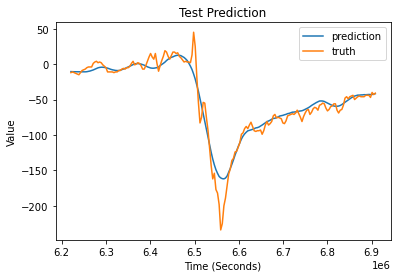

In [21]:
tester.plot(predictions, 9, 'DST1800')

Display all of the test data overlayed with the prediction values

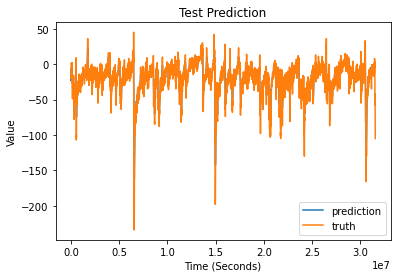

In [22]:
tester.plot(predictions, -1, 'DST1800')

Calculate the test errors (mae)

In [23]:
results = tester.plot(predictions, -1, 'DST1800', return_data=True)
extra = len(results['prediction'][1]) - len(results['truth'][1])  # the results may not lineup perfectly
extra

In [25]:
test_errors = np.abs(results['prediction'][1] - results['truth'][1][:-extra])

Explore test_errors

In [27]:
np.quantile(test_errors, .9999)  # 99.99 percentile

64.71515237121295

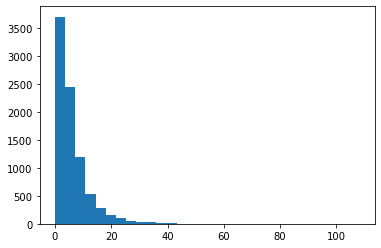

In [26]:
plt.hist(test_errors, bins=30)
plt.show()

Get different indexes of where test errors exceed threshold percentile

In [31]:
percentile = .999  # arbitrary
ndxs = np.where(test_errors > np.quantile(test_errors, percentile))[0]
pred_ndxs = np.floor(ndxs / tester.out_steps).tolist()
time_ndxs = ndxs * 60 * 60
# assuming start date of test data is Jan. 1st, 2015
dates = [datetime.utcfromtimestamp(x) for x in (time_ndxs + datetime(year=2015, month=1, day=1).timestamp())]

Listing outlier dates. Dates that occur close to each other, may be one event. 

In [32]:
dates

[datetime.datetime(2015, 1, 7, 7, 0),
 datetime.datetime(2015, 1, 7, 10, 0),
 datetime.datetime(2015, 1, 7, 11, 0),
 datetime.datetime(2015, 3, 17, 5, 0),
 datetime.datetime(2015, 3, 17, 6, 0),
 datetime.datetime(2015, 3, 17, 22, 0),
 datetime.datetime(2015, 3, 17, 23, 0),
 datetime.datetime(2015, 6, 22, 18, 0),
 datetime.datetime(2015, 6, 23, 4, 0)]

List all the indexes side by side with error values

In [33]:
list(zip(ndxs, pred_ndxs, time_ndxs, test_errors[ndxs]))[:2]  # liminting output

Plot all test data with dots representing outliers

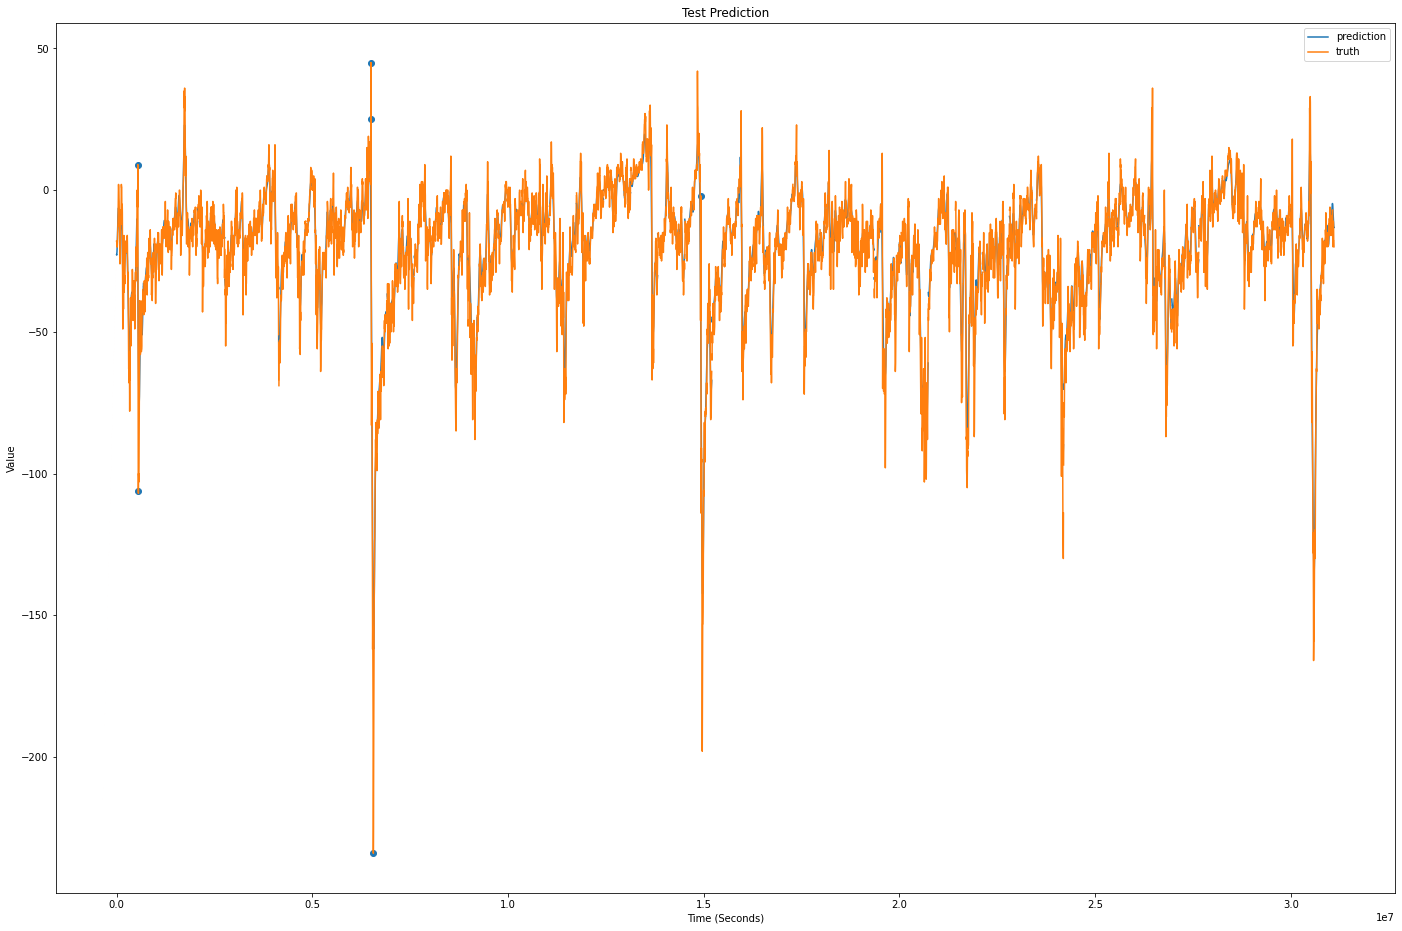

In [34]:
plt.figure(figsize=(24, 16))
for ndx in range(len(predictions)):
    tester.plot(predictions, ndx, 'DST1800')
    if ndx in pred_ndxs:
        start_ndx = pred_ndxs.index(ndx)
        end_ndx = len(pred_ndxs) - pred_ndxs[::-1].index(ndx) - 1
        plt.scatter(time_ndxs[start_ndx:end_ndx], results['truth'][1][ndxs[start_ndx:end_ndx]], color='C0')

### Conclusion

The outliers detected seem to signal some type of space storm and several times, if not the majority, are CMEs or Flares. However, the outliers are often those that have extreme values, while useful, the hope of a more complex outlier detector would be to recognize complicated patterns and signal when such patterns are not the norm. This argubly was achieved, but it seems that this simplified to extreme values.

©️ 2022 The Johns Hopkins University Applied Physics Laboratory LLC.